## A ***naive*** contextual-bandit approach to advertisment

In [641]:
import numpy as np
%matplotlib inline

rnd = np.random
rnd.seed(42)

# List of items
items = ["Car", "Watch", "T-shirt", "Computer", "Smartphone", 
         "Headphones", "Sunglasses", "NordVPN", "HogwardsLegacy"]

# The estimation's vector
Q = [1 for item in range(len(items))]

# The rewards' probabilities vector
R = [np.round(np.abs(rnd.normal(0.3,0.2)), 2) for item in range (len(items))]

In [642]:
# Tuning parameters

# Total number of iterations
ITERATIONS = int(10e5)

# Set the epsilon value for the epsilon-greedy search

# An higher epsilon value will increase the exploration, resulting in a better 
# estimation of all the items overall. A lower value, will focus the algorithm
# to exploit as much as possible, resulting in an high confidence estimation of the best one,
# but in a general bad approximation for the other items's Q.
EPSILON = 0.15

# The step value
ALPHA = 0.05

In [643]:
def update_estimation(est: float, 
                    reward: float,
                    step_size: int):
    '''
        Update the estimation, incrementally.

        Parameters
        ----------
        est: float
            Current estimation
        reward: float
            New reward obtained
        step_size: int 
            The inverse of the total number of rewards received if a stationary problem is considered. 
            Otherwise an alpha value (0,1].        
    '''

    return np.round(est + step_size*(reward - est),2)

In [644]:
# A sample item will be tracked
hstry_idx = 8
hstry = np.ones(ITERATIONS)

# Counter of the times that item has been chosen
A_n = np.zeros(len(items))

for step in range(1, ITERATIONS):

    # Check epsilon's value
    if rnd.random() < EPSILON:
        idx = rnd.randint(0,len(items))
    else: idx = np.argmax(Q, 0)

    # Get the reward, considering the relative item's probability to give it
    reward = 1 if rnd.rand() < R[idx] else 0

    # Update the counter
    A_n[idx]+=1

    Q[idx] = update_estimation(Q[idx], reward, ALPHA)

    # Using 1/A_n, stationary problem
    #Q[idx] = update_estimation(Q[idx], reward, (1/A_n[idx]))
    
    # Update the history of the sample item
    hstry[step] = Q[hstry_idx]

Text(0, 0.5, 'Value')

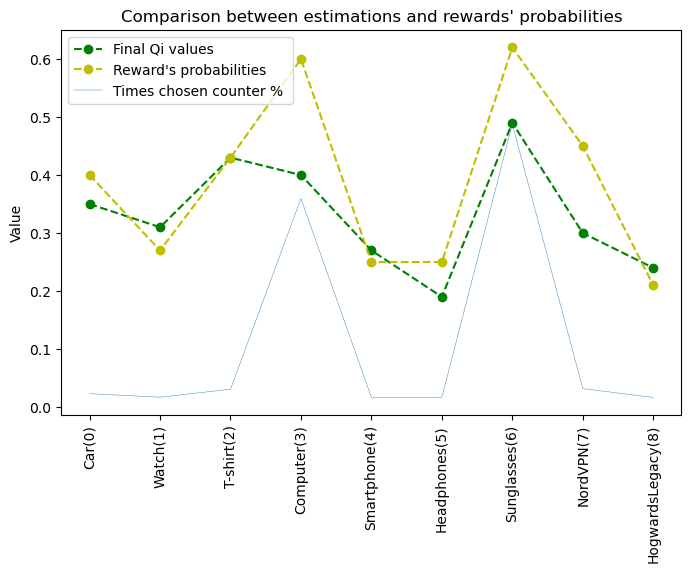

In [649]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
plt.title("Comparison between estimations and rewards' probabilities")
plt.plot(Q, "o--g")
plt.plot(R, "o--y")
plt.plot(A_n/ITERATIONS, "-",linewidth=0.3)

plt.legend(["Final Qi values", "Reward's probabilities", "Times chosen counter % "])
plt.xticks(ticks= np.arange(0,9), labels=[ f'{items[i]}({i})' for i in np.arange(0,9)], rotation=90)

plt.ylabel("Value")

Text(0, 0.5, 'Value')

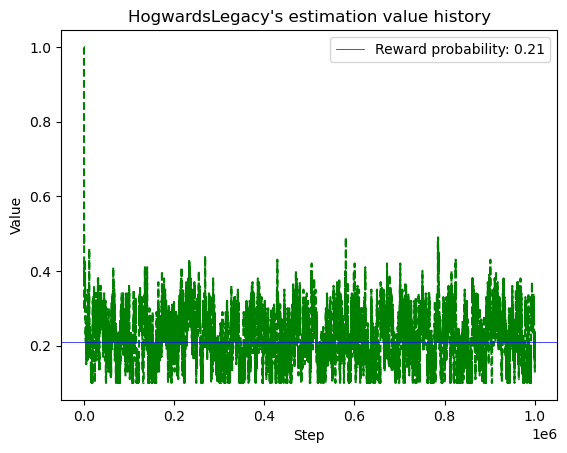

In [646]:
plt.plot(hstry, "--g")
plt.axhline(R[hstry_idx], color = "b", linewidth="0.5", label=f"Reward probability: {R[hstry_idx]}")
plt.legend()
plt.title(f"{items[hstry_idx]}'s estimation value history")
plt.xlabel("Step")
plt.ylabel("Value")
